In [23]:
import pandas as pd
import gurobipy 
from gurobipy import Model, GRB, quicksum
import numpy as np

#Loading the dataset 
brick_index_value = pd.read_csv('./bricks_index_values.csv')
brick_rp_distances = pd.read_csv('./brick_rp_distances.csv')
#distances= pd.read_csv('./distances.xlsx')
#pfizer =pd.read_csv('./Pfitzer10-100.csv', sep=';')

### 1. Objectif de minimisation de la distance

In [24]:
#Extracting data from the datasets
bricks = brick_index_value['brick'].tolist()
reps = list(range(1, 5))  # 4 représentants

#Converting distance to a dictionary f
distances = {
    row['brick']: [row[f'rp{i}'] for i in reps]
    for _, row in brick_rp_distances.iterrows()
}
#Converting index values to a dictionary
index_values = dict(zip(brick_index_value['brick'], brick_index_value['index_value']))

#Workload interval bounds
L = 0.8 
U = 1.2

#Modèle pour minimiser la distance
model_distance = Model("Minimize_Distance")

#Variables de décision 
#Variables binaires x[b, r], chaques briques b est assignée à un représentant r
x = model_distance.addVars(bricks, reps, vtype=GRB.BINARY, name="x") 

#Fonction objectif : minimiser la distance totale
model_distance.setObjective(
    quicksum(distances[b][r - 1] * x[b, r] for b in bricks for r in reps), GRB.MINIMIZE
)

#Chaque brique est assignée à un seul représentant
model_distance.addConstrs(
    (quicksum(x[b, r] for r in reps) == 1 for b in bricks), name="AssignEachBrick"
)

#Contraintes de charge de travail dans l'intervalle [L, U]
model_distance.addConstrs(
    (quicksum(index_values[b] * x[b, r] for b in bricks) >= L for r in reps), name="MinWorkload"
)

model_distance.addConstrs(
    (quicksum(index_values[b] * x[b, r] for b in bricks) <= U for r in reps), name="MaxWorkload"
)

#Optimisation
model_distance.optimize()

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 23.6.0 23G80)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 30 rows, 88 columns and 264 nonzeros
Model fingerprint: 0x4ea169f8
Variable types: 0 continuous, 88 integer (88 binary)
Coefficient statistics:
  Matrix range     [4e-02, 1e+00]
  Objective range  [8e-01, 5e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-01, 1e+00]
Found heuristic solution: objective 353.0700000
Presolve time: 0.00s
Presolved: 30 rows, 88 columns, 264 nonzeros
Variable types: 0 continuous, 88 integer (88 binary)

Root relaxation: objective 1.488198e+02, 25 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  148.81982    0    6  353.07000  148.81982  57.8%     -    0s
H    0     0                     1

In [25]:
# Affichage des résultats sous forme de tableau
if model_distance.Status == GRB.OPTIMAL:
    print("\nDistance totale minimale :", model_distance.ObjVal)
    results = []
    for b in bricks:
        for r in reps:
            if x[b, r].X > 0.5:
                results.append([b, r])

    # Création du DataFrame pour afficher les résultats
    results_df = pd.DataFrame(
        results, columns=['Brick', 'Représentant'])

results_df[['Brick', 'Représentant']]



Distance totale minimale : 154.62


,Brick,Représentant
0,1,4
1,2,4
2,3,4
3,4,1
4,5,1
5,6,1
6,7,1
7,8,1
8,9,1
9,10,3


### 2. Objectif minimisation de disruption

In [26]:
#Assignation initiale des briques aux représentants
initial_assignment = {
    4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 15: 1,   # SR 1
    10: 2, 11: 2, 12: 2, 13: 2, 14: 2,     # SR 2
    9: 3, 16: 3, 17: 3, 18: 3,             # SR 3
    1: 4, 2: 4, 3: 4, 19: 4, 20: 4, 21: 4, 22: 4  # SR 4
}

#Modèle pour minimiser la perturbation
model_disruption = Model("Minimize_Disruption")

#Variables de décision
x = model_disruption.addVars(bricks, reps, vtype=GRB.BINARY, name="x")
y = model_disruption.addVars(bricks, reps, vtype=GRB.BINARY, name="y")

#Fonction objectif : minimiser la perturbation pondérée par l'index
model_disruption.setObjective(
    quicksum(index_values[b] * y[b, r] for b in bricks for r in reps), GRB.MINIMIZE
)

#Contraintes
#Chaque brick doit être attribué à un seul représentant
model_disruption.addConstrs(
    (quicksum(x[b, r] for r in reps) == 1 for b in bricks), name="AssignEachBrick"
)

#Charge de travail dans l'intervalle [L, U]
model_disruption.addConstrs(
    (quicksum(index_values[b] * x[b, r] for b in bricks) >= L for r in reps), name="MinWorkload"
)
model_disruption.addConstrs(
    (quicksum(index_values[b] * x[b, r] for b in bricks) <= U for r in reps), name="MaxWorkload"
)

#Mesurer la perturbation
model_disruption.addConstrs(
    (y[b, r] >= x[b, r] - (1 if initial_assignment[b] == r else 0)
     for b in bricks for r in reps), name="Disruption"
)

#Résoudre le modèle
model_disruption.optimize()

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 23.6.0 23G80)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 118 rows, 176 columns and 440 nonzeros
Model fingerprint: 0xa736d90c
Variable types: 0 continuous, 176 integer (176 binary)
Coefficient statistics:
  Matrix range     [4e-02, 1e+00]
  Objective range  [4e-02, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-01, 1e+00]
Found heuristic solution: objective 2.6088000
Presolve removed 88 rows and 88 columns
Presolve time: 0.00s
Presolved: 30 rows, 88 columns, 264 nonzeros
Variable types: 0 continuous, 88 integer (88 binary)

Root relaxation: objective 1.377000e-01, 25 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.13770    0    4    2.60880    0.13770  94.7%     

In [27]:
# Afficher les résultats sous forme de tableau
if model_disruption.Status == GRB.OPTIMAL:
    print("\nPerturbation totale minimale :", model_disruption.ObjVal)
    results = []
    for b in bricks:
        for r in reps:
            if x[b, r].X > 0.5:
                results.append([b, r])

    # Création du DataFrame pour afficher les résultats
    results_df = pd.DataFrame(results, columns=['Brick', 'Représentant'])

results_df[['Brick', 'Représentant']]


Perturbation totale minimale : 0.1696


,Brick,Représentant
0,1,4
1,2,4
2,3,4
3,4,1
4,5,1
5,6,1
6,7,1
7,8,1
8,9,3
9,10,2


### 3. Epsilon Constraint

In [28]:
# Fonction pour déterminer les center bricks
def determine_center_bricks_from_distances(distances, reps):
    center_bricks = {}
    for r in reps:
        center_brick = min(
            distances.keys(), key=lambda b: distances[b][r - 1]
        )  # Trouver la brique la plus proche du centre pour chaque représentant

        center_bricks[r] = center_brick
    return center_bricks


# Fonction pour extraire la solution
def extract_solution(model, bricks, reps):
    assignment = {r: [] for r in reps}  # Initialiser les assignations
    assigned_bricks = set()  # Pour vérifier les doublons

    for b in bricks:
        assigned_rep = None
        for r in reps:
            var = model.getVarByName(f"x[{b},{r}]")
            if (
                var and var.x > 0.5
            ):  # Vérifier si la brique est assignée au représentant
                if b in assigned_bricks:
                    print(f"Warning: Brick {b} assigned to multiple representatives!")
                else:
                    assignment[r].append(b)
                    assigned_bricks.add(b)
                    assigned_rep = r
        if assigned_rep is None:
            print(f"Warning: Brick {b} not assigned to any representative!")

    return assignment


Initial maximum distance: 244.65

Solving for workload constraints: [0.8, 1.2]
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 23.6.0 23G80)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 119 rows, 176 columns and 524 nonzeros
Model fingerprint: 0x00392e93
Variable types: 0 continuous, 176 integer (176 binary)
Coefficient statistics:
  Matrix range     [4e-02, 5e+01]
  Objective range  [4e-02, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-01, 2e+02]
Found heuristic solution: objective 1.8370000
Presolve removed 88 rows and 88 columns
Presolve time: 0.00s
Presolved: 31 rows, 88 columns, 330 nonzeros
Variable types: 0 continuous, 88 integer (88 binary)

Root relaxation: objective 1.377000e-01, 28 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | I

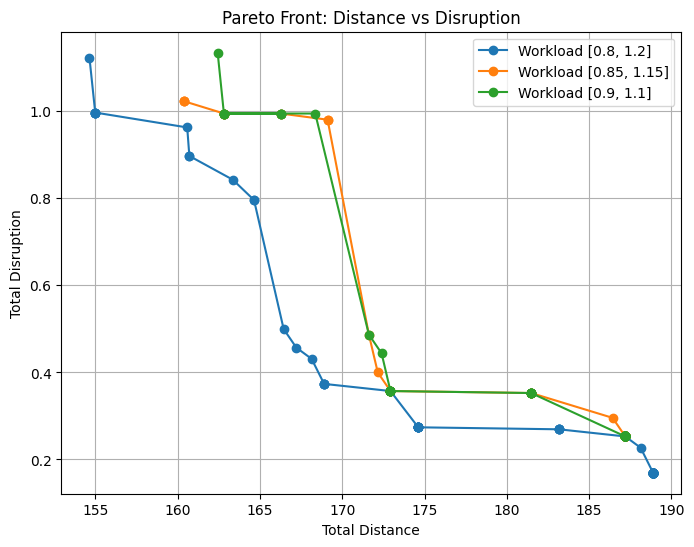

In [29]:
import matplotlib.pyplot as plt

#Workload bounds to test
workload_bounds = [(0.8, 1.2), (0.85, 1.15), (0.9, 1.1)]

def epsilon_constraint_scheme(initial_assignment, max_distance, workload_bounds):
    pareto_solutions = []
    epsilon = max_distance  #Initial upper bound for distance
    epsilon_step = 1  #Step to decrease epsilon

    #Iterate over different workload constraints
    for L, U in workload_bounds:
        print(f"\nSolving for workload constraints: [{L}, {U}]")
        epsilon = max_distance  #Reset epsilon for each workload bound

        #Start epsilon-constraint loop
        while epsilon >= 0:
            #Define model
            model = Model("Epsilon_Constraint")

            #Decision variables
            x = model.addVars(bricks, reps, vtype=GRB.BINARY, name="x")
            y = model.addVars(bricks, reps, vtype=GRB.BINARY, name="y")

            #Objectives
            total_distance = quicksum(distances[b][r - 1] * x[b, r] for b in bricks for r in reps)
            total_disruption = quicksum(index_values[b] * y[b, r] for b in bricks for r in reps)

            #Objective: minimize disruption
            model.setObjective(total_disruption, GRB.MINIMIZE)

            #Constraints
            model.addConstrs((quicksum(x[b, r] for r in reps) == 1 for b in bricks), name="AssignEachBrick")
            model.addConstr(total_distance <= epsilon, name="Epsilon_Distance")
            model.addConstrs((y[b, r] >= x[b, r] - (1 if initial_assignment.get(b, None) == r else 0)
                              for b in bricks for r in reps), name="Disruption")
            model.addConstrs((quicksum(index_values[b] * x[b, r] for b in bricks) >= L for r in reps), name="MinWorkload")
            model.addConstrs((quicksum(index_values[b] * x[b, r] for b in bricks) <= U for r in reps), name="MaxWorkload")

            #Optimize the model
            model.optimize()

            #Check feasibility and store solutions
            if model.Status == GRB.OPTIMAL:
                solution_distance = total_distance.getValue()
                solution_disruption = total_disruption.getValue()
                assignment = extract_solution(model, bricks, reps)
                pareto_solutions.append((L, U, solution_distance, solution_disruption,assignment))
                print(f"Solution found: Distance = {solution_distance}, Disruption = {solution_disruption}")
            else:
                print(f"No feasible solution for epsilon: {epsilon} and workload [{L}, {U}]")

            #Reduce epsilon
            epsilon -= epsilon_step

    return pareto_solutions

#Compute Pareto solutions
max_distance = sum(distances[b][0] for b in bricks) 
print(f"\nInitial maximum distance: {max_distance}")
pareto_solutions = epsilon_constraint_scheme(initial_assignment, max_distance, workload_bounds)

#Plot the set of non-dominated solutions
def plot_pareto_solutions(pareto_solutions):
    plt.figure(figsize=(8, 6))
    for L, U in set((L, U) for L, U, _, _, _ in pareto_solutions):
        subset = [(d, dis) for (lb, ub, d, dis, _) in pareto_solutions if lb == L and ub == U]
        distances, disruptions = zip(*subset)
        plt.plot(distances, disruptions, marker='o', linestyle='-', label=f"Workload [{L}, {U}]")
    plt.xlabel("Total Distance")
    plt.ylabel("Total Disruption")
    plt.title("Pareto Front: Distance vs Disruption")
    plt.legend()
    plt.grid(True)
    plt.show()

#Print the set of non-dominated solutions
print("\nSet of Non-Dominated Solutions:")
for L, U, distance, disruption, assignment in pareto_solutions:
    print(f"Workload [{L}, {U}] - Distance: {distance}, Disruption: {disruption}")

#Plot the Pareto front
plot_pareto_solutions(pareto_solutions)

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
import matplotlib.colors as mcolors

def rotate_symmetry(points: np.ndarray, theta: float) -> np.ndarray:
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])
    rotated_points = [np.dot(rotation_matrix, point) for point in points]
    return np.array([[x, -y] for (x, y) in rotated_points])

def get_positions_city(distances: np.ndarray) -> np.ndarray:
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42, max_iter=1000)
    positions = mds.fit_transform(distances)
    return rotate_symmetry(positions, -2 * np.pi / 3)

def get_color_attribution(attribution: dict) -> dict:
    color_list = list(mcolors.TABLEAU_COLORS)
    color_attribution = {}
    for sr_id in attribution:
        assigned_bricks = attribution[sr_id]["Assigned bricks"]
        for brick in assigned_bricks:
            color_attribution[brick] = color_list[sr_id]
    return color_attribution

def plot_cities_attribution(assignment: dict, distances_matrix) -> None:
    positions = get_positions_city(distances_matrix)
    color_attribution = get_color_attribution(assignment)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(
        positions[:, 0],
        positions[:, 1],
        color=[color_attribution[city] for city in range(len(color_attribution))],
        s=50
    )
    
    for i, (x, y) in enumerate(positions):
        plt.text(
            x - 0.2,
            y + 0.2,
            f"{i}",  # Using 0-based indexing
            fontsize=8,
            ha="right",
            weight="bold" if any(i == assignment[sr_id]["Center brick"] for sr_id in assignment) else None
        )
    
    plt.title("Attribution des villes aux commerciaux")
    plt.axis("equal")
    plt.grid(True)
    plt.show()

# Après votre code de calcul Pareto, ajoutez :
for L, U, distance, disruption, assignment in pareto_solutions:
    print(f"\nSolution pour workload [{L}, {U}]:")
    print(f"Distance: {distance:.2f}, Disruption: {disruption:.2f}")
    print("Attribution:", assignment)
    plot_cities_attribution(assignment, distances)  # Utilisez votre matrice de distances existante


Solution pour workload [0.8, 1.2]:
Distance: 188.89, Disruption: 0.17
Attribution: {1: [4, 5, 6, 7, 8, 15], 2: [10, 13, 14], 3: [9, 11, 12, 16, 17, 18], 4: [1, 2, 3, 19, 20, 21, 22]}


ValueError: Expected 2D array, got scalar array instead:
array={np.float64(1.0): [np.float64(16.16), np.float64(24.09), np.float64(24.29), np.float64(21.12)], np.float64(2.0): [np.float64(19.0), np.float64(26.47), np.float64(27.22), np.float64(17.33)], np.float64(3.0): [np.float64(25.29), np.float64(32.5), np.float64(33.41), np.float64(12.25)], np.float64(4.0): [np.float64(0.0), np.float64(7.94), np.float64(8.29), np.float64(36.12)], np.float64(5.0): [np.float64(3.07), np.float64(6.45), np.float64(7.55), np.float64(37.37)], np.float64(6.0): [np.float64(1.22), np.float64(7.51), np.float64(8.17), np.float64(36.29)], np.float64(7.0): [np.float64(2.8), np.float64(10.3), np.float64(10.92), np.float64(33.5)], np.float64(8.0): [np.float64(2.87), np.float64(5.07), np.float64(5.65), np.float64(38.8)], np.float64(9.0): [np.float64(3.8), np.float64(8.02), np.float64(7.37), np.float64(38.16)], np.float64(10.0): [np.float64(12.35), np.float64(4.51), np.float64(4.37), np.float64(48.27)], np.float64(11.0): [np.float64(11.11), np.float64(3.51), np.float64(2.97), np.float64(47.14)], np.float64(12.0): [np.float64(21.99), np.float64(22.01), np.float64(24.1), np.float64(39.86)], np.float64(13.0): [np.float64(8.82), np.float64(3.28), np.float64(5.38), np.float64(43.31)], np.float64(14.0): [np.float64(7.94), np.float64(0.0), np.float64(2.1), np.float64(43.75)], np.float64(15.0): [np.float64(9.34), np.float64(2.32), np.float64(1.11), np.float64(45.43)], np.float64(16.0): [np.float64(8.29), np.float64(2.1), np.float64(0.0), np.float64(44.4)], np.float64(17.0): [np.float64(7.28), np.float64(2.4), np.float64(1.08), np.float64(43.4)], np.float64(18.0): [np.float64(7.55), np.float64(0.77), np.float64(1.54), np.float64(43.52)], np.float64(19.0): [np.float64(11.13), np.float64(18.41), np.float64(19.24), np.float64(25.4)], np.float64(20.0): [np.float64(17.49), np.float64(23.44), np.float64(24.76), np.float64(23.21)], np.float64(21.0): [np.float64(11.03), np.float64(18.94), np.float64(19.26), np.float64(25.43)], np.float64(22.0): [np.float64(36.12), np.float64(43.75), np.float64(44.4), np.float64(0.0)]}.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.